Aperçu du dataset:
   Age Situation maritale  Nb enfants  Nb pers à charge  Profession du mari  \
0   60        célibataire           0                 1                   1   
1   46             mariée           1                 1         agriculteur   
2   60             mariée           4                 1  infirmier retraité   
3   48             mariée           5                 0          mécanicien   
4   43             mariée           3                 0        a l'étranger   

   Domicile Niveau socio-économique Tabagisme Fumées de Tabouna  \
0  monastir                monastir       non               oui   
1  monastir                     bon       non               oui   
2  monastir                     bon       non               oui   
3  monastir                   moyen       non               oui   
4  monastir                     bon       non               oui   

  Antécédents familiaux  ...  TAS TAD   GAD  Examen des membres supérieurs  \
0         cardiopathies  

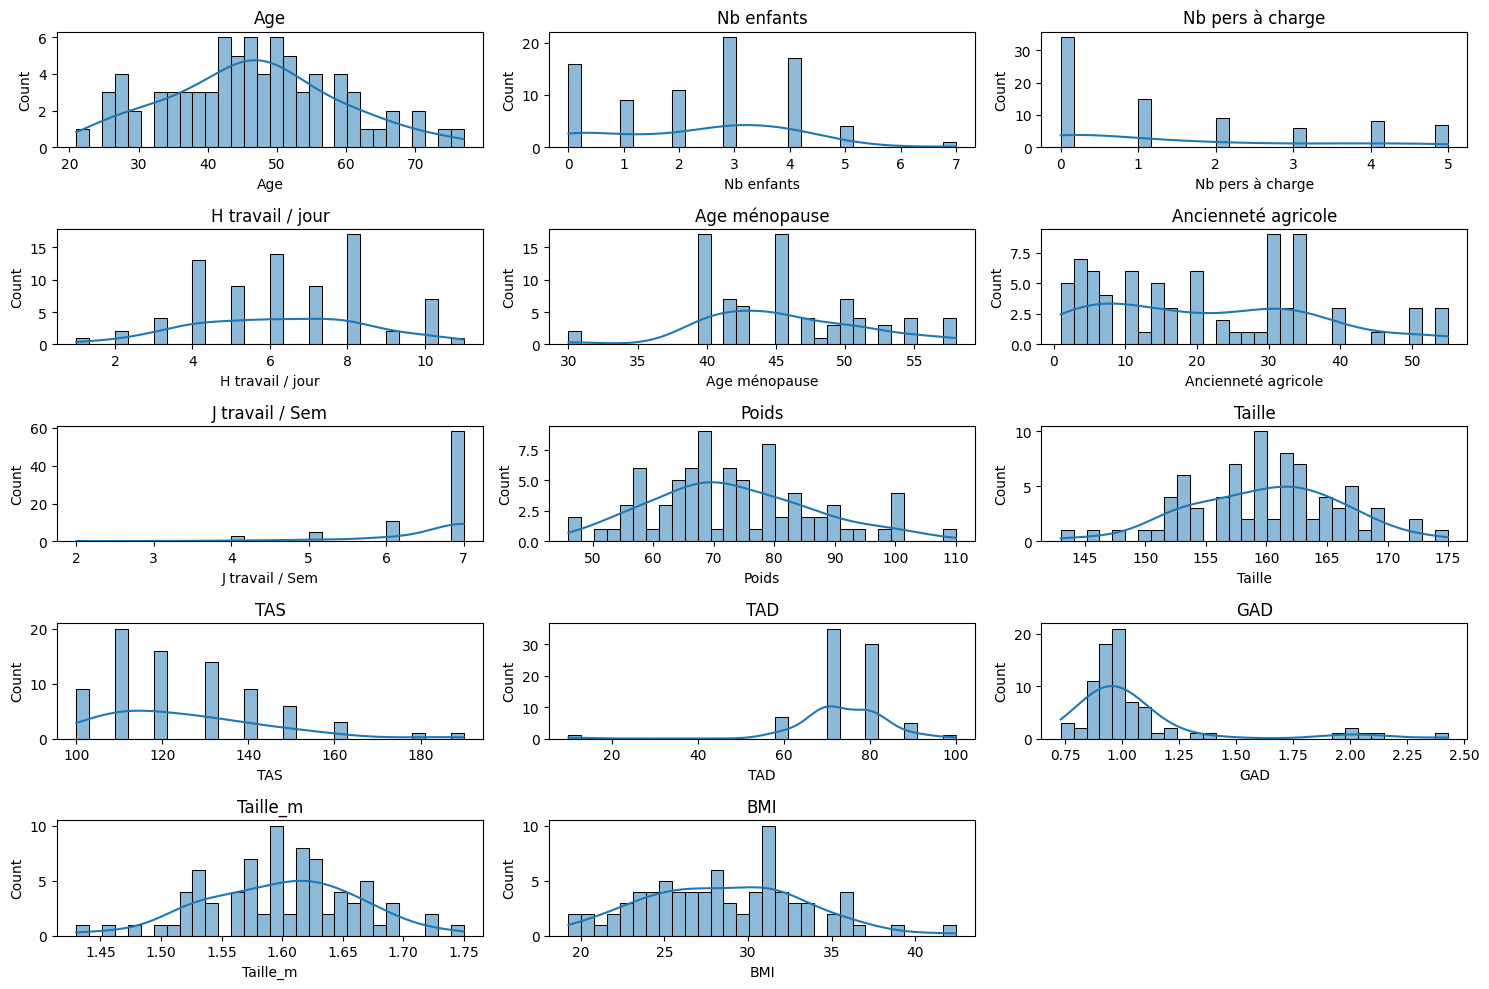

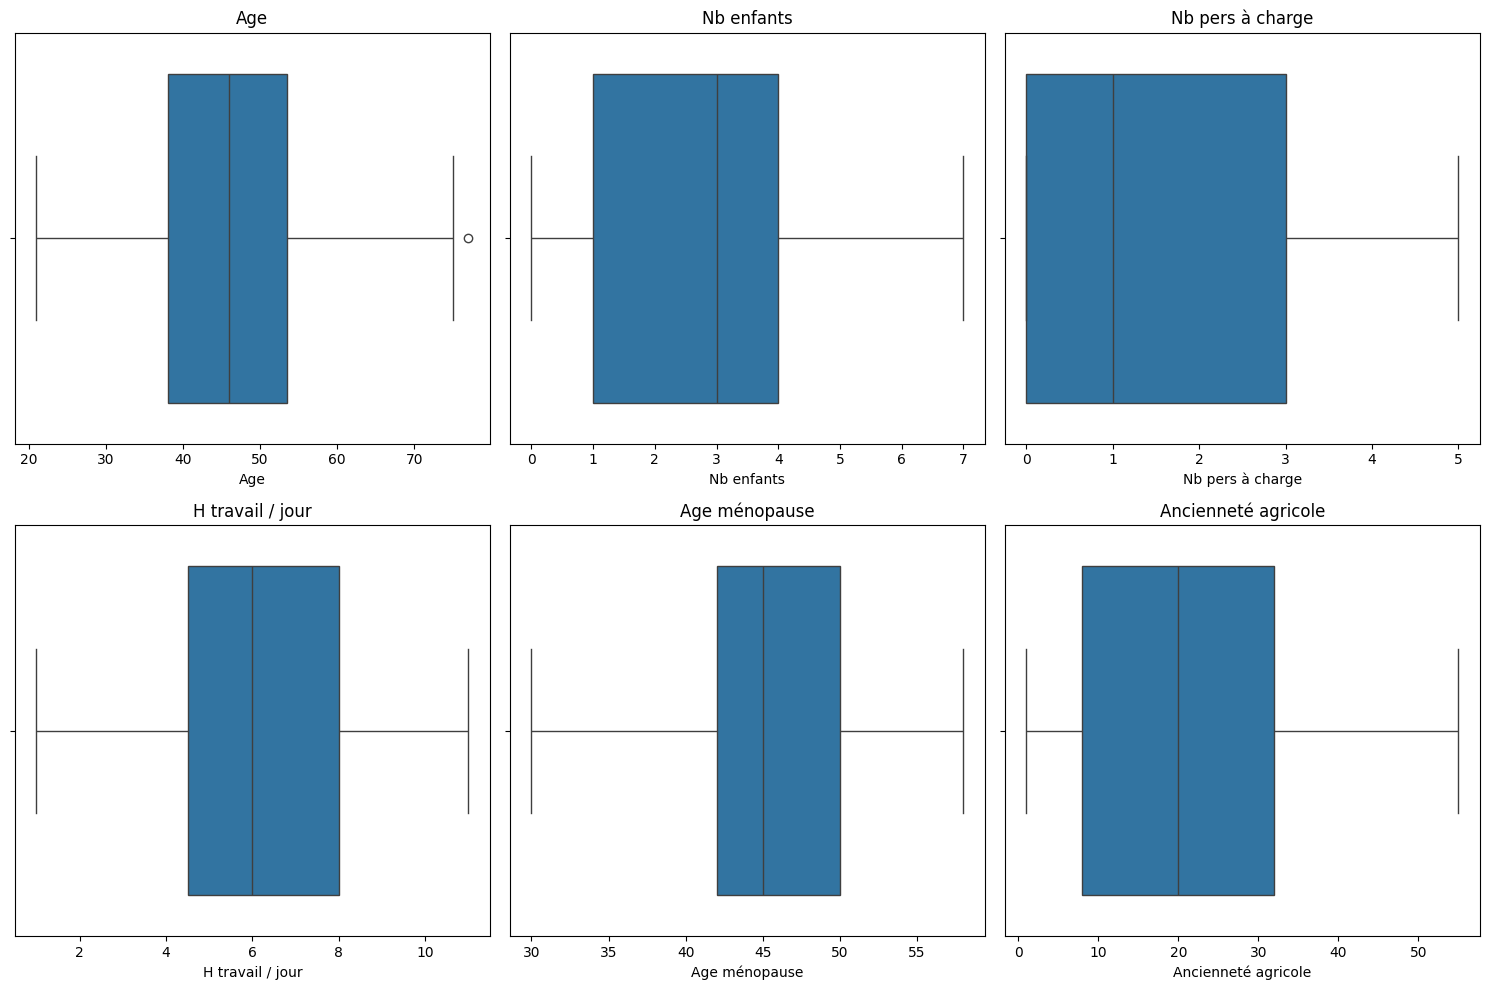

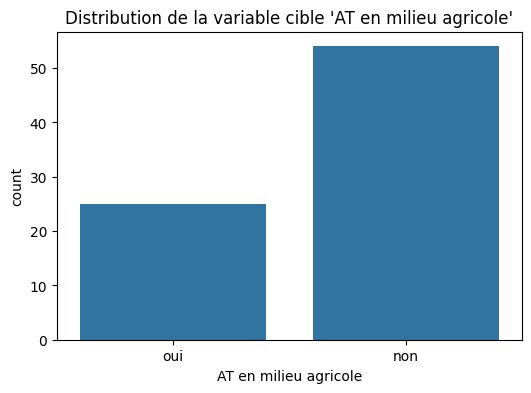

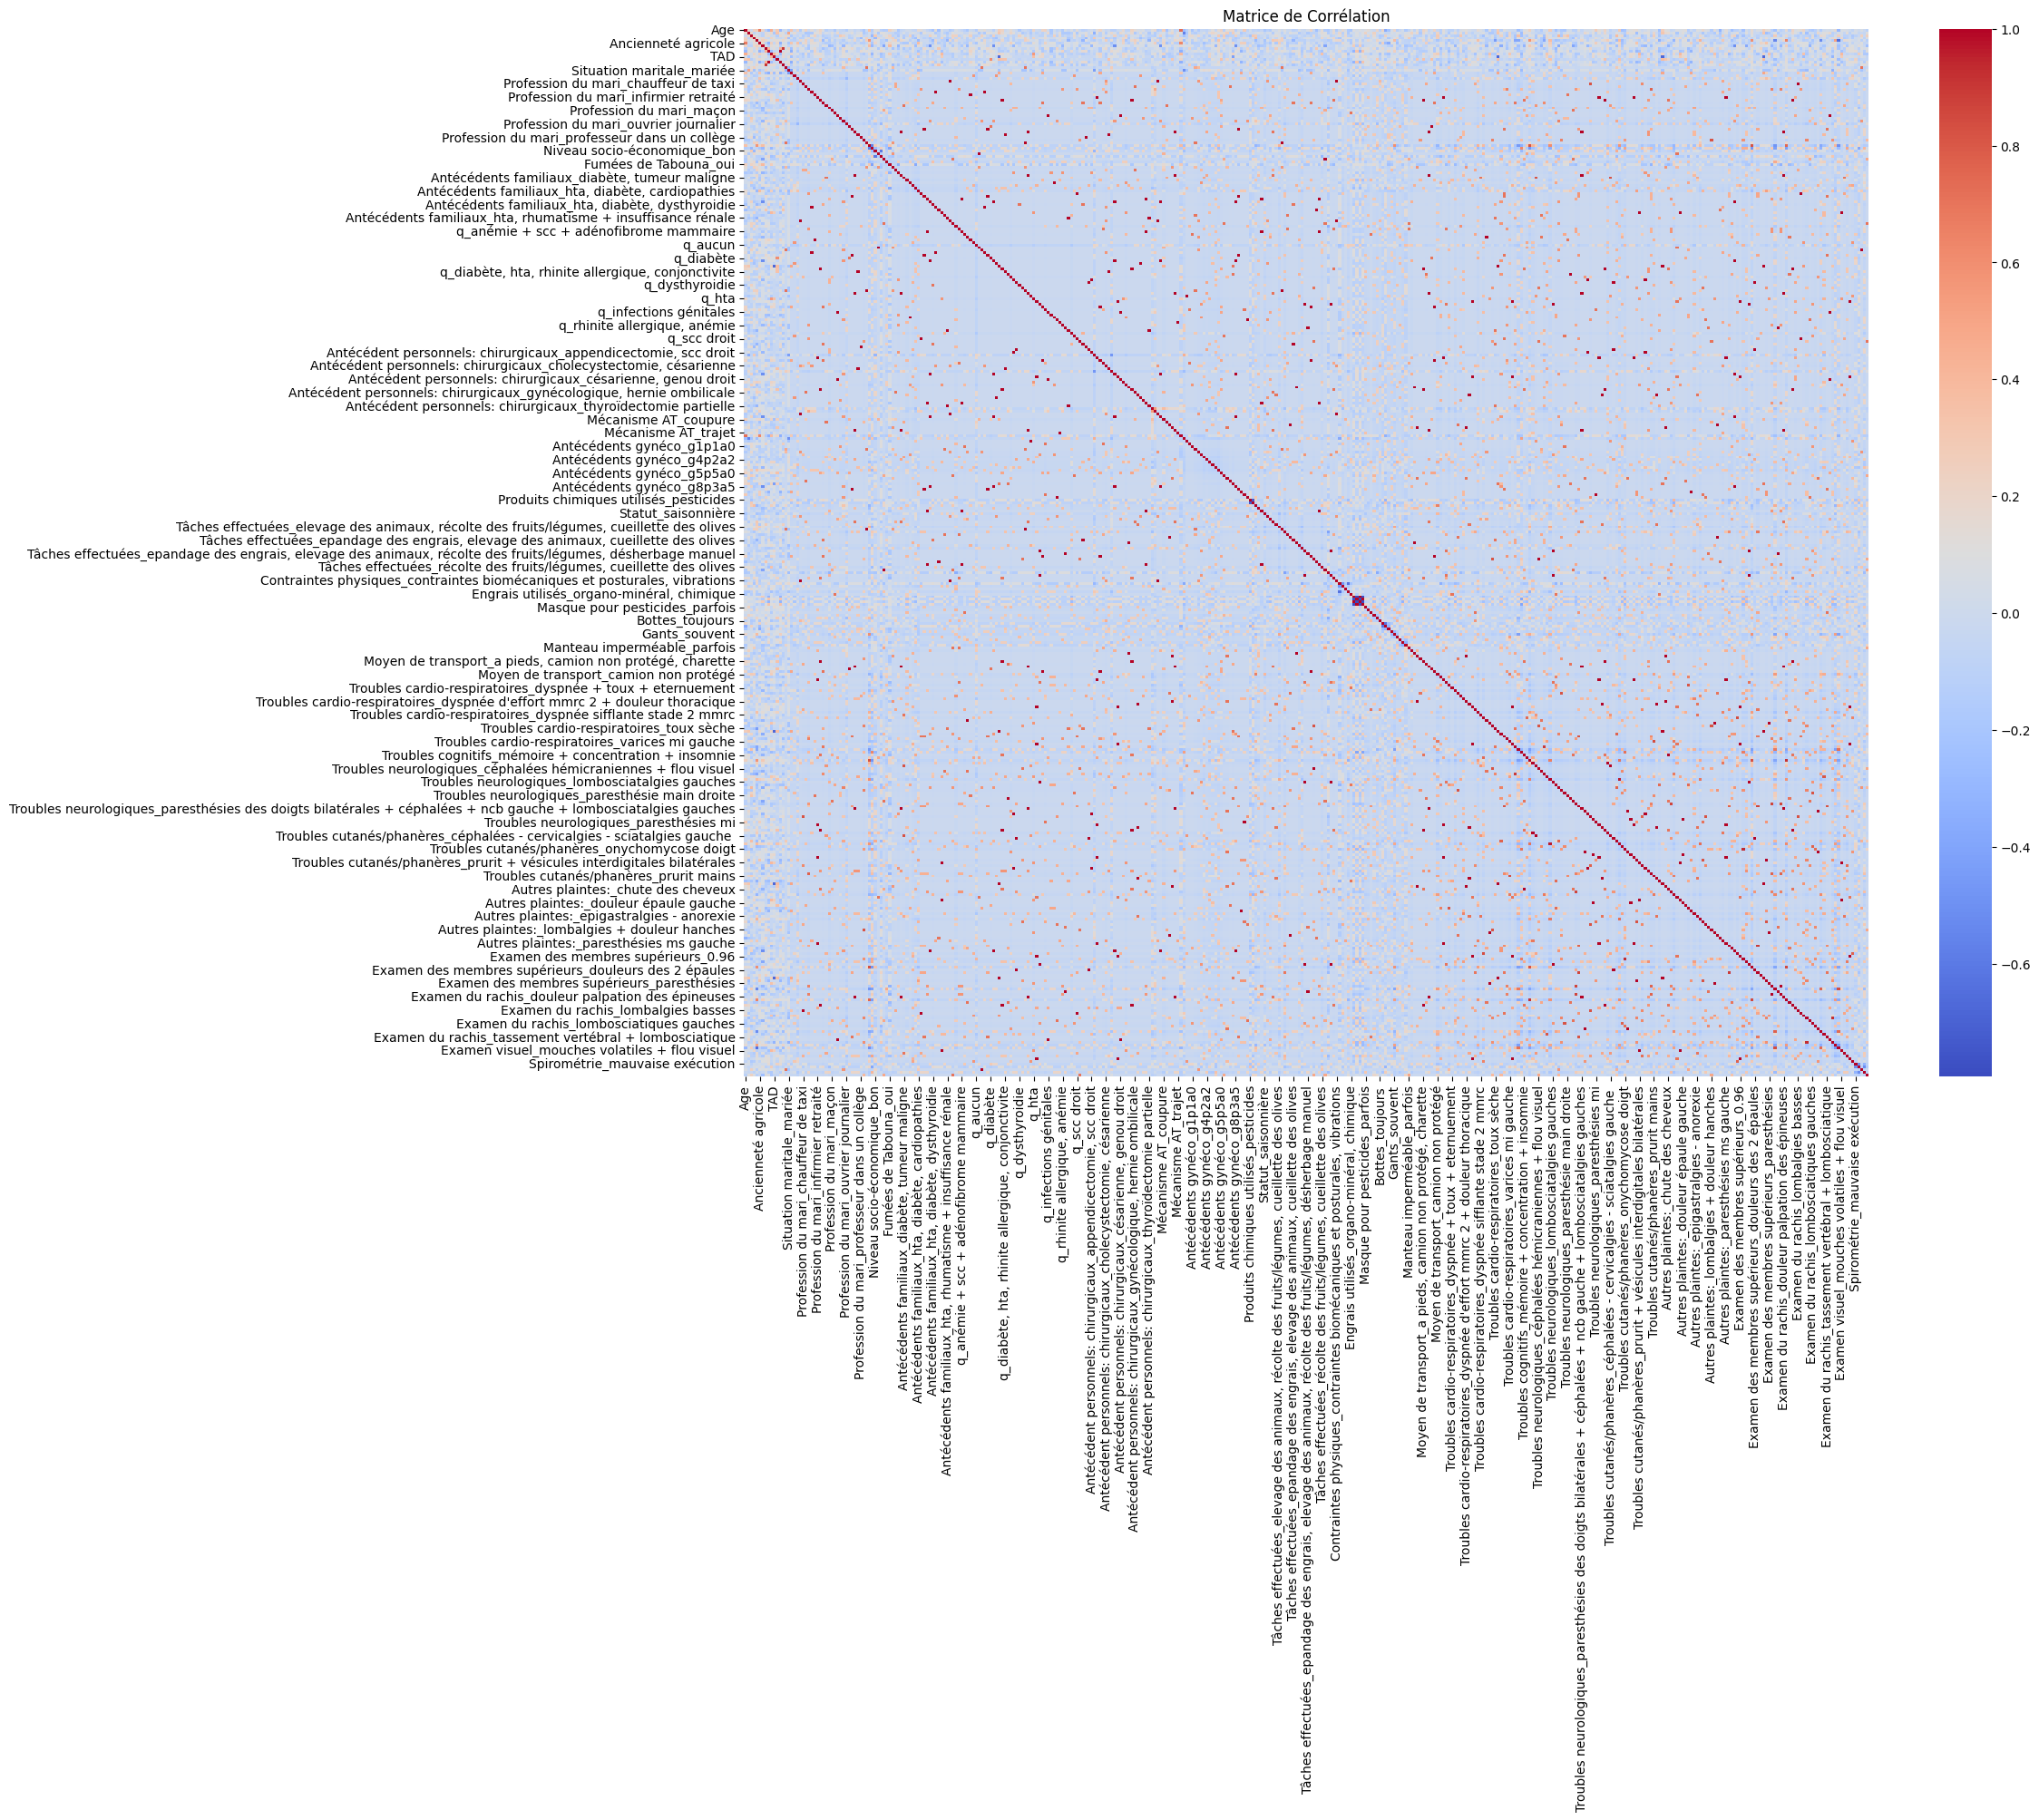

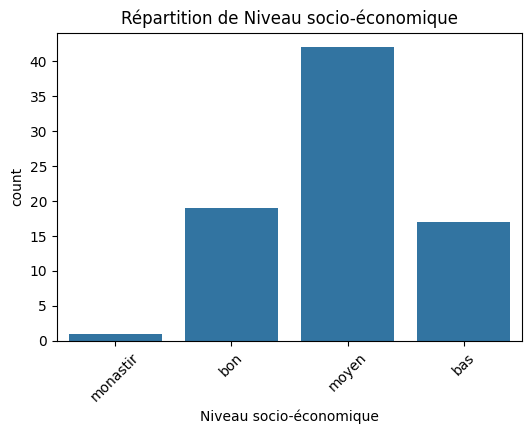

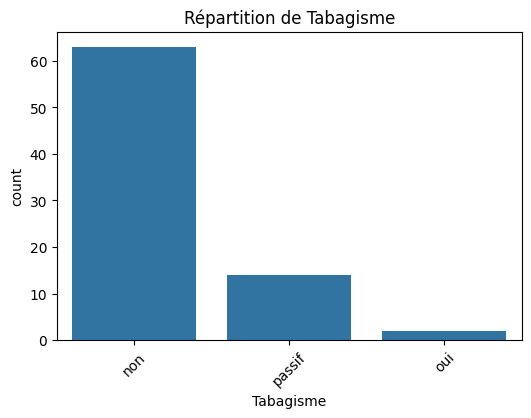

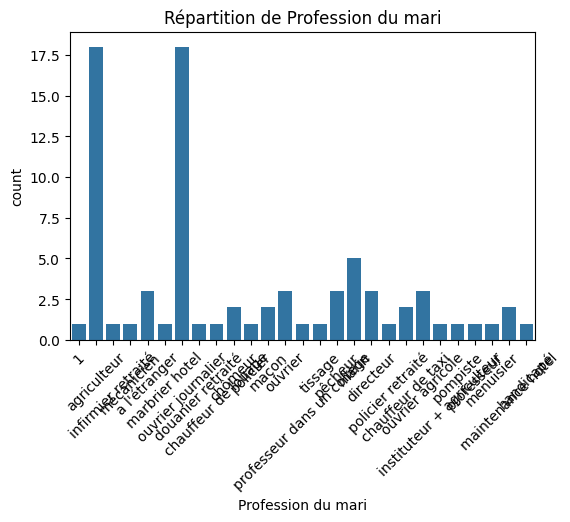


Dimensions des features après encodage : (79, 389)

Variables sélectionnées : ['Profession du mari_chômeur', 'Profession du mari_marin', 'Domicile_monastir', 'Antécédents familiaux_hta, diabète', 'q_rhumatisme', 'Mécanisme AT_chute', 'Mécanisme AT_coupure', 'Mécanisme AT_morsure chien', 'Antécédents gynéco_g4p3a1', 'Antécédents gynéco_g5p3a2', 'Antécédents gynéco_g6p5a1', 'Antécédents gynéco_g7p7a0', 'Catégorie professionnelle_ouvrière', 'Catégorie professionnelle_ouvrière, agricultrice indépendante', 'Statut_saisonnière', 'Tâches effectuées_elevage des animaux, cueillette des olives, désherbage manuel', 'Tâches effectuées_elevage des animaux, récolte des fruits/légumes, cueillette des olives, désherbage manuel', 'Tâches effectuées_epandage des engrais, elevage des animaux, récolte des fruits/légumes, cueillette des olives, désherbage manuel', "Contraintes physiques_contraintes biomécaniques et posturales, contraintes mécaniques (risque d'at)", 'Engrais utilisés_organique, chimique', 

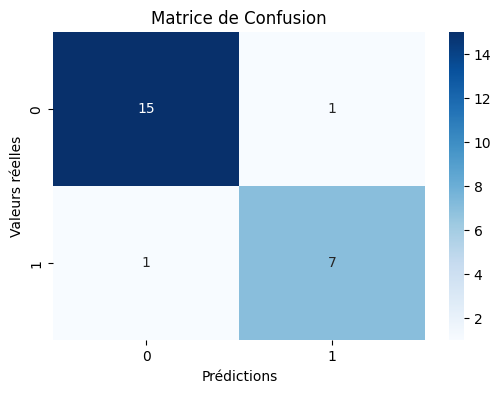

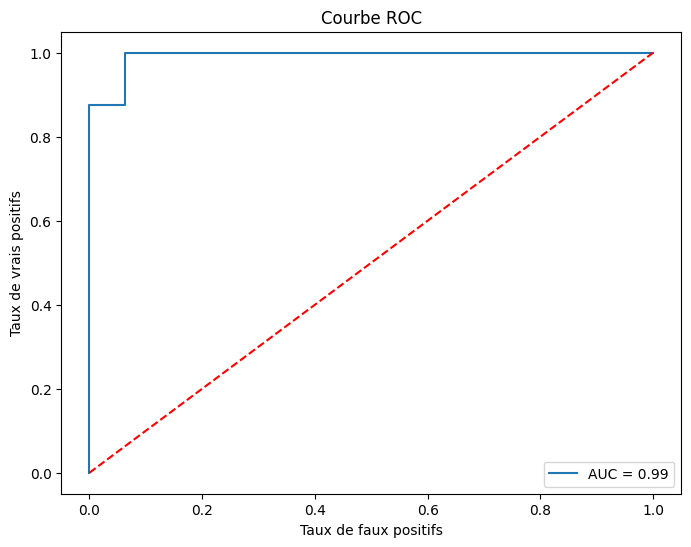

✅ Score AUC ROC moyen (5-fold CV): 0.92


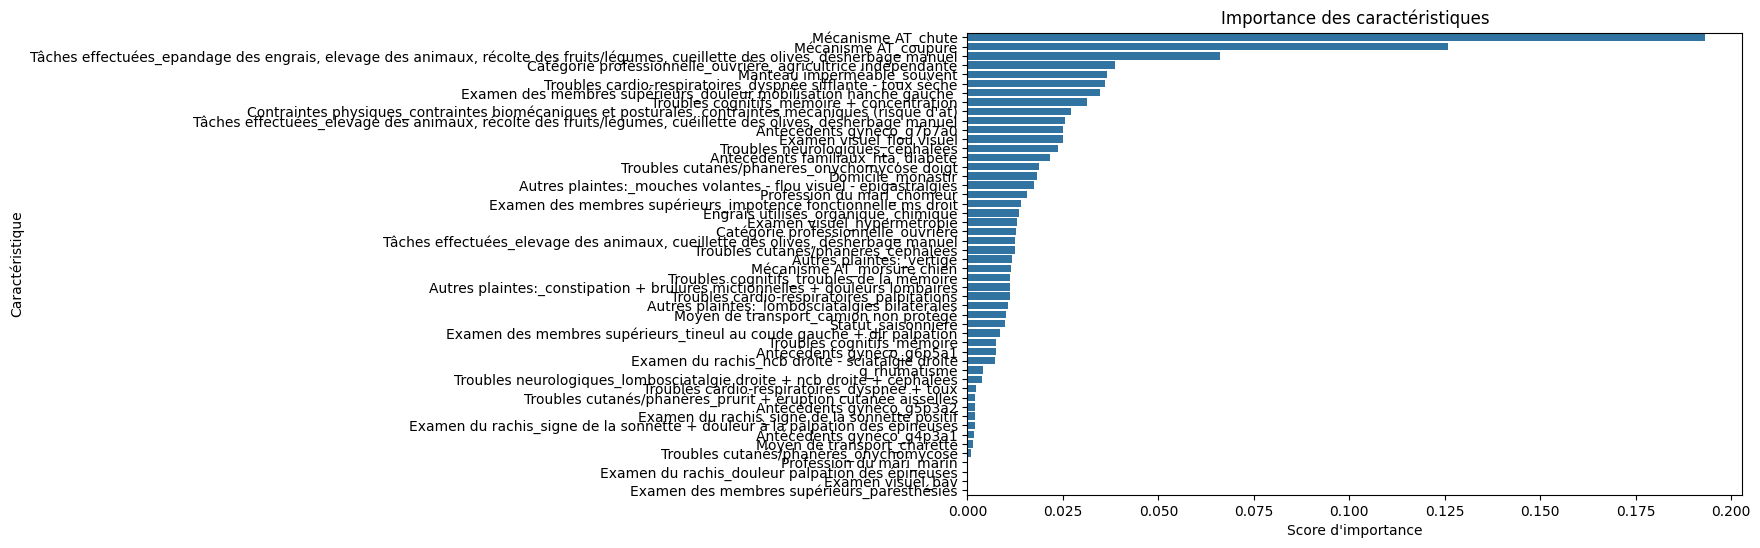

✅ Modèle RandomForest sauvegardé sous 'modele_rf.pkl'.


In [1]:
# =============================================================================
# SECTION 1 : Importation des bibliothèques nécessaires
# =============================================================================
import pandas as pd                # Manipulation des données
import numpy as np                 # Calculs numériques
import matplotlib.pyplot as plt    # Visualisations
import seaborn as sns              # Visualisations avancées
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE  # Pour équilibrer les classes
import joblib                      # Pour sauvegarder le modèle
import math                        # Pour le calcul de la grille dans les plots

# Pour afficher les graphiques directement dans le notebook
%matplotlib inline

# =============================================================================
# SECTION 2 : Chargement du jeu de données
# =============================================================================
file_path = "/content/final_Dataset2.csv"  # Mettez à jour le chemin si nécessaire
df = pd.read_csv(file_path)

print("Aperçu du dataset:")
print(df.head())
print("\nInformations générales sur le dataset:")
print(df.info())

# =============================================================================
# SECTION 3 : Préparation et nettoyage des données
# =============================================================================
# 3.1 Suppression des colonnes inutiles
cols_to_drop = ['N°', 'Nom', 'Prénom', 'N° du téléphone']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True, errors='ignore')

# 3.2 Remplacement des valeurs manquantes :
# - Pour les colonnes numériques : remplacement par la médiane
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# - Pour les colonnes catégorielles : remplacement par le mode (valeur la plus fréquente)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nNombre de valeurs manquantes après traitement:")
print(df.isnull().sum())

# =============================================================================
# SECTION 4 : Analyse exploratoire des données (EDA) et Visualisations
# =============================================================================

# 4.1 Statistiques descriptives
print("\nStatistiques descriptives:")
print(df.describe())

# 4.2 Histogrammes des variables numériques
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(math.ceil(len(num_cols)/3), 3, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# 4.3 Boxplots pour détecter les outliers (affichage de quelques variables)
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:6], 1):  # Affichage des 6 premières variables numériques
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 4.4 Répartition de la variable cible 'AT en milieu agricole'
plt.figure(figsize=(6, 4))
sns.countplot(x='AT en milieu agricole', data=df)
plt.title("Distribution de la variable cible 'AT en milieu agricole'")
plt.show()

# 4.5 Matrice de corrélation (après encodage pour inclure les variables catégorielles)
df_encoded_full = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(20, 15))
sns.heatmap(df_encoded_full.corr(), cmap='coolwarm', annot=False)
plt.title("Matrice de Corrélation")
plt.show()

# 4.6 Visualisations de variables catégorielles importantes (si elles existent)
for col in ['Niveau socio-économique', 'Tabagisme', 'Profession du mari']:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, data=df)
        plt.title(f"Répartition de {col}")
        plt.xticks(rotation=45)
        plt.show()

# =============================================================================
# SECTION 5 : Préparation pour la modélisation prédictive
# =============================================================================
# Définir la variable cible (target)
target_col = 'AT en milieu agricole'
if target_col not in df.columns:
    raise ValueError(f"La colonne cible '{target_col}' n'existe pas dans le dataset.")

y = df[target_col]
X = df.drop(columns=[target_col])

# Encodage des variables catégorielles pour les features
X_encoded = pd.get_dummies(X, drop_first=True)
print("\nDimensions des features après encodage :", X_encoded.shape)

# =============================================================================
# SECTION 6 : Sélection des variables (SelectKBest)
# =============================================================================
# On sélectionne les 50 variables les plus pertinentes pour éviter la malédiction de la dimension
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_encoded, y)
selected_feature_names = X_encoded.columns[selector.get_support()]
print("\nVariables sélectionnées :", list(selected_feature_names))

# =============================================================================
# SECTION 7 : Découpage en ensembles d'entraînement et de test
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)
print("\nTaille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

# =============================================================================
# SECTION 8 : Équilibrage des classes avec SMOTE (pour corriger les déséquilibres)
# =============================================================================
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("\nAprès SMOTE, forme de l'ensemble d'entraînement :", X_train_bal.shape)

# =============================================================================
# SECTION 9 : Construction et entraînement du modèle prédictif
# =============================================================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_bal, y_train_bal)

# =============================================================================
# SECTION 10 : Évaluation du modèle
# =============================================================================
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n✅ Rapport de classification :")
print(classification_report(y_test, y_pred))

# 10.1 Matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Blues')
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Valeurs réelles")
plt.show()

# 10.2 Courbe ROC et calcul de l'AUC
# Pour roc_curve, si la cible est sous forme de chaînes ('oui'/'non'), utiliser pos_label='oui'
try:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label='oui')
except Exception as e:
    print("Erreur avec pos_label='oui', utilisation de pos_label=1")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

auc_score = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title("Courbe ROC")
plt.legend(loc='lower right')
plt.show()

# 10.3 Validation croisée (5-fold CV)
cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='roc_auc')
print("✅ Score AUC ROC moyen (5-fold CV): {:.2f}".format(cv_scores.mean()))

# =============================================================================
# SECTION 11 : Visualisation de l'importance des caractéristiques
# =============================================================================
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=selected_feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Importance des caractéristiques")
plt.xlabel("Score d'importance")
plt.ylabel("Caractéristique")
plt.show()

# =============================================================================
# SECTION 12 : Sauvegarde du modèle
# =============================================================================
joblib.dump(model, 'modele_rf.pkl')


print("✅ Modèle RandomForest sauvegardé sous 'modele_rf.pkl'.")

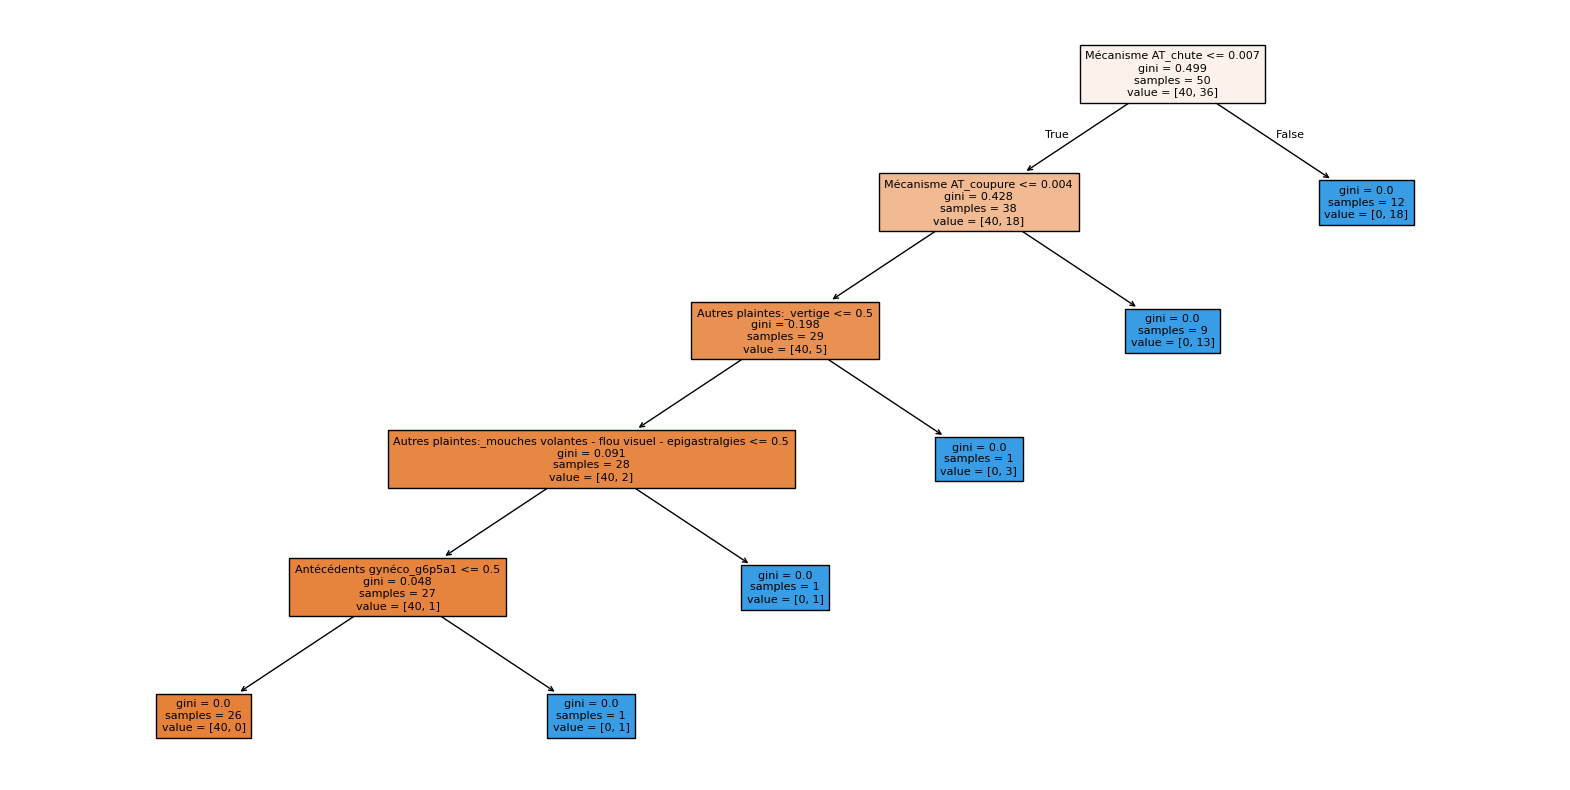

In [2]:
# extraction des règles
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=list(selected_feature_names), filled=True, fontsize=8)
plt.show()


In [3]:
from sklearn.tree import export_text

# Parcourir chaque arbre de la forêt aléatoire et extraire ses règles
for i, arbre in enumerate(model.estimators_[:3]):  # On affiche seulement les 3 premiers arbres pour éviter un trop gros affichage
    print(f"\n🔹 Règles de l'arbre {i+1} :\n")
    rules = export_text(arbre, feature_names=list(selected_feature_names))
    print(rules)


🔹 Règles de l'arbre 1 :

|--- Mécanisme AT_chute <= 0.01
|   |--- Mécanisme AT_coupure <= 0.00
|   |   |--- Autres plaintes:_vertige <= 0.50
|   |   |   |--- Autres plaintes:_mouches volantes - flou visuel - epigastralgies <= 0.50
|   |   |   |   |--- Antécédents gynéco_g6p5a1 <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Antécédents gynéco_g6p5a1 >  0.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- Autres plaintes:_mouches volantes - flou visuel - epigastralgies >  0.50
|   |   |   |   |--- class: 1.0
|   |   |--- Autres plaintes:_vertige >  0.50
|   |   |   |--- class: 1.0
|   |--- Mécanisme AT_coupure >  0.00
|   |   |--- class: 1.0
|--- Mécanisme AT_chute >  0.01
|   |--- class: 1.0


🔹 Règles de l'arbre 2 :

|--- Mécanisme AT_chute <= 0.01
|   |--- Troubles cognitifs_troubles de la mémoire <= 0.50
|   |   |--- Examen des membres supérieurs_douleur mobilisation hanche gauche  <= 0.50
|   |   |   |--- Mécanisme AT_coupure <= 0.50
|   |   |   |   |--- Mant